In [1]:
import numpy as np
from scipy import stats as st
from scipy import optimize as opt
import matplotlib.pyplot as plt
from typing import Tuple, List, Set
import math

## Problem Description

We have $n$ pairs of independent identically distributed observations $(X_i, Y_i), i = 1, \dots, n$. 

$$
P(X_i = 0, Y_i = 0) = p_{00} \\
P(X_i = 0, Y_i = 1) = p_{01} \\
P(X_i = 1, Y_i = 0) = p_{10} \\
P(X_i = 1, Y_i = 1) = p_{11} \\
$$

We want to test the hypothesis that 

$$H_0: EX = EY$$

against the alternative 

$$ H_1: EX < EY. $$ 

$ H_0 $ is equivalent to 

$$ p_{10} + p_{11} = p_{01} + p_{11} $$

which is equivalent to 

$$ p_{10} = p_{01}. $$

## Ad-hoc Frequentist Approach

Define $Z_{01}$ the number of cases $(X,Y) = (0,1)$ (similarly define $Z_{00}, Z_{10}, Z_{11}$).

We have

$$ P(Z_{01} | Z_{01} + Z_{10} = m) \sim Bi \big(m, \frac{p_{01}}{p_{01} + p_{10}} \big) $$

the term on right hand side is $ Bi(m, 0.5) $ under $ H_0 $. (TODO: There must be some additional assumptions so we can follow this line of thought, what are they exactly?) 

So if $ H_0 $ were true the probability we get observation $ Z_{01} $ or an observation which we would say is even more in favor of $ H_1 $ than the observed $Z_{01}$ (this is the p-value) is

$$ 1 - \mathrm{cdf}_{Bi(m, 0.5)}\big (Z_{01} - 1 \big ) $$

If this probability is very low, for example $5 \%$, we reject $ H_0 $ in favour of $ H_1 $.

**Note**

Consider two following sequences of $ (X,Y)_i $ for $ n = 9 $, each of these has $\sum X_i = 3$ and $\sum Y_i = 6$

**CASE A: ** (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (1,0), (1,0), (1,0)

$$ 
m = 9, Z_{01} = 6 \\
1 - \mathrm{cdf}_{Bi(m, 0.5)} \doteq 0.377 
$$

**CASE B: ** (1,1), (1,1), (1,1), (0,1), (0,1), (0,1), (0,0), (0,0), (0,0)

$$
m = 3, Z_{01} = 3 \\
1 - \mathrm{cdf}_{Bi(m, 0.5)} = 0.125 
$$

From this we can see, that having only the information about $\sum X_i$ and $\sum Y_i$ is not sufficient. In fact the p-value in case A is almost 3 times larger than the p-value in case B!

In [2]:
def calculate_significance_level(m: int, z_01: int) -> float: 
    """ Probability we will measure statistic 
    that is more in favour of H_1 then our measurement """
    p_0 = 0.5
    alpha = 1 - st.binom.cdf(k=z_01-1, n=m, p=p_0)
    return alpha 

In [3]:
print(f"In case A the significance level is {calculate_significance_level(9, 6)} \n"\
      f"in case B it is {calculate_significance_level(3, 3)}")

In case A the significance level is 0.25390625 
in case B it is 0.125


**Test your guess**

If we have $m = 100$, how many times must $Y > X$ so we can say it is 'better' with $80\%$ confidence?

In [4]:
m = 100
p_0 = 0.5
confidence = 0.80
answer = 2*((m/2) - st.binom.ppf(1 - confidence, m, p_0))
print(f"The answer is {answer}")

The answer is 8.0


## Ad-hoc Bayesian Approach

Denote $ p_{01}^{*} = \frac{p_{01}}{p_{01} + p_{10}} $

The previous frequentist approach was basically a test whether $ H_0: p_{01}^{*} = 0.5 $ against the alternative $ H_1: p_{01}^{*} > 0.5 $

In Bayesian view $ p_{01}^{*} $ is not a fixed parameter but a random variable. It is reasonable to assume it's prior is distributed according to $ Beta(\alpha, \alpha) $ (this is standard symmetric distribution on interval [0,1], we choose symmetric if we have no prior reason to believe $X$ is better / worse than $Y$). We can calculate posterior of $ p_{01}^{*} $ and from that we can for example calculate the probability that posterior of $ p_{01}^{*} $ is greater than $ 0.5 $ or better yet the one-sided credibility interval for $p_{01}^{*}.$ If this interval lies to the right of $0.5$ we can say $Y > X$ with probability for example $0.9$. 

In addition we can also make claims such as $Y$ can't be worse than $X$ by more than $20\%$ with probability more than $1\%$. 

**Technical details**

TODO: think about additional assumptions you are making here (see Ad-hoc Frequentist approach). 

We have $ Z_{01} | p^*_{01}, m \sim Bi(m, p^*_{01}) $ 
and 
$ p_{01}^* \sim Beta(\alpha, \alpha) $ from which (using the [well known relation](https://en.wikipedia.org/wiki/Conjugate_prior#Discrete_distributions) for posterior in the beta binomial case) we have 

$$
p_{01}^* | Z_{01}, m \sim Beta( \alpha + Z_{01}, \alpha + m - Z_{01}) 
$$

The parameter $\alpha$ must be selected on case-by-case basis (the higher it's value the greater our prior belief about $X = Y$). Let's for now assume $\alpha = 1$ which corresponds to the prior of $p_{01}^*$ beiing a uniform distribution on $[0,1]$.

In [5]:
def plot_beta_density(alpha: float, beta: float, label: str = None):
    """ Plot probability density function of Beta(alpha, beta) """
    grid_density = 100
    x = np.linspace(0,1,grid_density)
    y = st.beta.pdf(x, alpha, beta)
    plt.plot(x, y, label = label)

In [6]:
def posterior_alpha_beta(alpha: float, beta: float, n: int, k: int) -> Tuple[float]: 
    """ Calculate posterior parameters of p with prior Beta(alpha, beta) 
        Given observation: k ones out of n iid trials where each trial | p ~ Alt(p)
    """
    return alpha + k, beta + n - k

In [7]:
def plot_posterior(alpha: float, beta: float, n: int, k: int, label: str = None) -> Tuple[float]: 
    alpha_posterior, beta_posterior = posterior_alpha_beta(alpha, beta, n, k)
    plot_beta_density(alpha_posterior, beta_posterior, label)

In [8]:
def posterior_quantile(q: float, alpha: float, beta: float, n: int, k: int) -> float: 
    alpha_posterior, beta_posterior = posterior_alpha_beta(alpha, beta, n, k)
    quantile = st.beta.ppf(q, alpha_posterior, beta_posterior)
    return quantile

In [9]:
def posterior_cdf(x: float, alpha: float, beta: float, n: int, k: int) -> float: 
    alpha_posterior, beta_posterior = posterior_alpha_beta(alpha, beta, n, k)
    probability = st.beta.cdf(x, alpha_posterior, beta_posterior)
    return probability

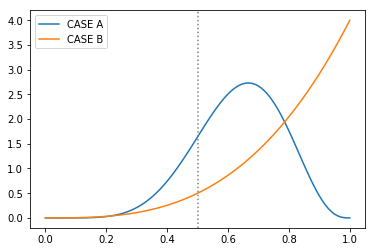

In [10]:
alpha = 1.0

plot_posterior(alpha, alpha, 9, 6, "CASE A")
plot_posterior(alpha, alpha, 3, 3, "CASE B")
plt.legend()
plt.axvline(x=0.5, color="gray", ls="dotted")

In [11]:
print(f"Probability of posterior >= 0.5: \n\n"
      f"case A: {np.round(1 - posterior_cdf(0.5, 1., 1., 9, 6), 2)} \n"
      f"case B: {np.round(1 - posterior_cdf(0.5, 1., 1., 3, 3), 2)} \n\n"
      f"We are 90% confident that Y is better than X by at least: \n\n"
      f"case A: {np.round(2*(posterior_quantile(1 - 0.9, 1., 1., 9, 6) - 0.5), 2)*100} % \n"
      f"case B: {np.round(2*(posterior_quantile(1 - 0.9, 1., 1., 3, 3) - 0.5), 2)*100} %")

Probability of posterior >= 0.5: 

case A: 0.83 
case B: 0.94 

We are 90% confident that Y is better than X by at least: 

case A: -10.0 % 
case B: 12.0 %


## Conceptual Frequentist Approach

The universal frequentist approach is based on the likelihood ratio: 

$$
\mathrm{lr}(z) = \frac{\mathrm{sup}_{p \in B_1} L(p, z)}{\mathrm{sup}_{p \in B_0} L(p, z)}
$$

where 

- $z$ is element of the observation space
- $p$ is element of the parameter space
- $L$ is the likelihood function
- $B_0, B_1$ are subsets of the parameter space that correspond to $H_0$ resp. $H_1$

In our case we have $p = (p_{00}, p_{10}, p_{01}, p_{11})$. $B_1$ is the set $\lbrace p: \sum p_{ij} = 1\rbrace$ and $B_0$ is the set $\lbrace p: \sum p_{ij} = 1, p_{01} = p_{10}\rbrace$. Observation space is the space off all sequences of length $n$ of pairs with elements $0$ or $1$. 

So in our case we have $L(p,y) = \frac{n!}{z_{00}!z_{01}!z_{10}!z_{11}!}p_{00}^{z_{00}} p_{01}^{z_{01}} p_{10}^{z_{10}} p_{11}^{z_{11}}$ and after solving what the supremas are -- use for example Lagrange multipliers, but it is quite intuitive -- we have

$$
\mathrm{lr}(z) = \frac{(\frac{z_{00}}{n})^{z_{00}}(\frac{z_{01}}{n})^{z_{01}}(\frac{z_{10}}{n})^{z_{10}}(\frac{z_{11}}{n})^{z_{11}}}{(\frac{z_{00}}{n})^{z_{00}} (\frac{(z_{01} + z_{10})}{2n})^{z_{01} + z_{10}}   (\frac{z_{11}}{n})^{z_{11}}}
$$

which is equal to 

$$
\mathrm{lr}(z) = \frac{z_{01}^{z_{01}} z_{10}^{z_{10}}}{(\frac{z_{01}+z_{10}}{2})^{z_{01}+z_{10}}}
$$

p-value in this case is defined as 

$$
p-val = \mathrm{sup}_{p \in B_0} \mathbb{P}\big (lr(Z) \geq lr(z^{obs}) | p \big)
$$

it can be calculated numerically. 

In [12]:
def likelihood_ratio(z_01: float, z_10: float) -> float: 
    lr = z_10**z_10 * z_01**z_01 / ((z_10 + z_01)/2)**(z_01 + z_10)
    return lr

In [13]:
def sums(n: int, k: int) -> Set[Tuple[int]]: 
    """ All possible distinct integer non-negative k-tuples that sum up to n """
    if n == 0: 
        return set([(0,)*k])
    else: 
        res = set()
        for i in range(k): 
            for s in sums(n-1, k):
                s_copy = list(s)
                s_copy[i] = s_copy[i]+1
                res.add(tuple(s_copy))
                
    return res

In [14]:
def multinomial_pdf(n: int, z: List[int], p: List[float]) -> float: 
    """ Ugly ugly, stats does not support :( """
    log_pdf = math.log(math.factorial(n)) - \
              sum([math.log(math.factorial(zi)) for zi in z]) + \
              sum([zi*math.log(pi) for zi,pi in zip(z,p)])
    
    return math.exp(log_pdf)

In [15]:
def p_val(lr: float, p_00: float, p_01: float, p_10: float, p_11: float, n: int) -> float:
    probability = 0
    for s in sums(n, 4): 
        z_00, z_01, z_10, z_11 = s
        lr_s = likelihood_ratio(z_01, z_10)
        if lr_s >= lr:
            probability += multinomial_pdf(n, s, [p_00, p_01, p_10, p_11]) 
            
    return probability

Now we just need to maximize the `p_val` function on $\lbrace p : \sum p_{ij} = 1, p_{ij} \geq 0\rbrace$. Can be easily done using scipy.optimize. TODO: as implemented now it is VERY inefficient, make faster

In [16]:
# Case A, p-val ~ 0.36
# n = 9
# z_01, z_10 = 6,3

# Case B, p-val ~ 0.043
n = 9
z_01, z_10 = 3,0

# Start calculating p-value

lr_obs = likelihood_ratio(z_01, z_10)

p_0 = [0.25]*4

def objective(p): 
    return p_val(lr_obs, p[0], p[1], p[2], p[3], n)

def constraint_1(p): 
    return sum(p) - 1

def constraint_2(p):
    return p[1] - p[2]

b = (0., 1.)
bounds = (b,b,b,b)

con_1 = {"type": "eq", "fun": constraint_1}
con_2 = {"type": "eq", "fun": constraint_2}
constraints = [con_1, con_2]

solution = opt.minimize(fun=objective, x0=p_0, method='SLSQP', \
                        bounds=bounds, constraints=constraints)

In [17]:
print(solution)

     fun: 0.04358006742154446
     jac: array([0.3918338 , 0.39231807, 0.39231807, 0.3918338 ])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.10058914, 0.39941085, 0.39941085, 0.10058915])


## Conceptual Bayesian Approach [the way to go]

TODO